**@author: James V. Talwar**

# Autoimmune SNPs: Effect on Age of Diagnosis in Discovery and Validation Cohorts

**About:** This notebook provides the code needed to generate Figure 2 panel F (and relevant statistical anlyses) from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). These analyses investigated 30 autoimmune SNPs with age of diagnosis in both discovery and validation cohorts. These SNPs included four with established vitiligo-melanoma associations either as the joint lead risk SNP for both conditions (rs1126809, rs6059655) or in strong linkage disequilibrium with known cutaneous melanoma risk SNPs (rs72928038, rs251464), and one (rs9468925) that is associated with both psoriasis and vitiligo and falls in between HLA-C/HLA-B. The remaining 25 AI SNPs are broadly associated with autoimmunity (i.e., associated with at least three autoimmune conditions, and at least one of which surpassed a GWAS significance of $p = 10^{-7}$) and were previously investigated in the context of immune-checkpoint inhibitor success in melanoma by [Chat et al](https://link.springer.com/article/10.1007/s00262-019-02318-8).


## 1. Import Packages; Load and Pre-Process Data

In [1]:
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.transforms import Affine2D
import seaborn as sns
import numpy as np
import math
from scipy import stats
import statsmodels.formula.api as smf
import tqdm
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist())
autoimmuneAlleles

{'HLA-B13:02',
 'HLA-B27:05',
 'HLA-B39:06',
 'HLA-B51:01',
 'HLA-B57:01',
 'HLA-C06:02',
 'HLA-C12:03'}

**TCGA:**

Load in TCGA summary dataframe (MHC-I genotypes, Age of Diagnosis, Sex, etc.):

In [3]:
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]

Load in TCGA Chat/Kirchoff SNPs (25 AI-ICB SNPS) extracted via PLINK:

In [4]:
kirchoffTCGA = pd.read_csv("../GenotypeData/AutoimmuneSNPGenotypes/TCGA/tcga.25.raw", sep = " ", index_col = 0)
kirchoffTCGA = kirchoffTCGA[kirchoffTCGA.index.isin(tcgaSummary.index)] #filter down to the TCGA melanoma individuals 
tcgaSummary = tcgaSummary[tcgaSummary.index.isin(kirchoffTCGA.index)] #ensure consistency across DFs in terms of indexes (in case genotypes were unable to be extracted for any individuals)

Load in 4 melanoma-vitiligo SNPs and 1 psoriasis-vitiligo SNP that falls in between HLA-C/HLA-B in TCGA:

In [5]:
#There are 2 files as plink required running in both orientations to extract all 5 SNPs - first file
oneWay = pd.read_csv("../GenotypeData/AutoimmuneSNPGenotypes/TCGA/TCGA_Vitiligo_SNPs.raw", sep = " ", index_col = 0)
oneWay = oneWay[oneWay.index.isin(kirchoffTCGA.index)]

#second file
otherWay = pd.read_csv("../GenotypeData/AutoimmuneSNPGenotypes/TCGA/TCGA_Vitiligo_SNPs_OtherWay.raw", sep = " ", index_col = 0)
otherWay = otherWay[otherWay.index.isin(kirchoffTCGA.index)]

Filter down TCGA Summary and Chat/Kirchoff SNP DFs down to the same dimension as other AI SNP dataframes for consistency in analyses:

In [6]:
kirchoffTCGA = kirchoffTCGA[kirchoffTCGA.index.isin(oneWay.index)]

In [7]:
tcgaSummary = tcgaSummary[tcgaSummary.index.isin(oneWay.index)]

*Sanity Check:* So indexes align across all TCGA SNP DFs?

In [8]:
print("Index Consistency? --> {}".format(set(tcgaSummary.index) == set(kirchoffTCGA.index) == set(oneWay.index) == set(otherWay.index)))

Index Consistency? --> True


Concatenate TCGA summary information and AI SNP genotypes in one dataframe: 

In [9]:
skipThese = {"IID", "PAT", "MAT", "SEX", "PHENOTYPE"}
megaEvolution = pd.concat([tcgaSummary, kirchoffTCGA], axis = 1)
megaEvolution = megaEvolution.drop(list(skipThese), axis = 1)

megaEvolution = pd.concat([megaEvolution, oneWay], axis = 1)
megaEvolution = megaEvolution.drop(list(skipThese), axis = 1)

megaEvolution = pd.concat([megaEvolution, otherWay], axis = 1)
megaEvolution = megaEvolution.drop(list(skipThese), axis = 1)

**Validation**:

Load in RSID to LOC mapping file so SNP indexing across datasets is consistent:

In [10]:
mappingFile = pd.read_csv("../Data/hg19_avsnp147.txt", sep = "\t", header = None)
mappingFile.columns = ["chr", "start", "end", "maj", "min", "RSID"]
mappingFile.head()

/cellar/users/jtalwar/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,chr,start,end,maj,min,RSID
0,1,10019,10020,TA,T,rs775809821
1,1,10020,10020,A,-,rs775809821
2,1,10055,10055,-,A,rs768019142
3,1,10055,10055,T,TA,rs768019142
4,1,10108,10108,C,T,rs62651026


Load in the Chat/Kirchoff SNPs for validation set:

In [11]:
ukbbKirchoff = pd.read_csv("../GenotypeData/AutoimmuneSNPGenotypes/UKBB/ukbb.25.raw", sep = "\t", index_col = 0)

Load in summary validation (UKBB) dataframe (MHC-I genotypes, Age of Diagnosis, Sex, etc.):

In [12]:
ukbbSummary = pd.read_csv("../GenotypeData/UKBB.tsv", sep = "\t", index_col =0)

#Ensure AI MHC allele status is correct and all individuals are >= 20:
ukbbSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in ukbbSummary.iterrows()]
ukbbSummary = ukbbSummary[ukbbSummary["Age at Diagnosis"] >= 20]

Ensure consistency between the indexes of the summary file and the AI SNP file (in case any individuals AI SNPs were unable to be extracted):

In [13]:
ukbbKirchoff = ukbbKirchoff[ukbbKirchoff.index.isin(ukbbSummary.index)]
ukbbSummary = ukbbSummary[ukbbSummary.index.isin(ukbbKirchoff.index)]

Load in the other 5 AI SNPs (vitiligo-melanoma - 4; and psoriasis-vitiligo - 1):

In [14]:
chr5 = pd.read_csv("../GenotypeData/AutoimmuneSNPGenotypes/UKBB/chr5.raw", sep = "\t", index_col = 0)
chr5 = chr5[chr5.index.isin(set(ukbbKirchoff.index))]

In [15]:
chr6 = pd.read_csv("../GenotypeData/AutoimmuneSNPGenotypes/UKBB/chr6.raw", sep = "\t", index_col = 0)
chr6 = chr6[chr6.index.isin(set(ukbbKirchoff.index))]

In [16]:
chr11 = pd.read_csv("../GenotypeData/AutoimmuneSNPGenotypes/UKBB/chr11.raw", sep = "\t", index_col = 0)
chr11 = chr11[chr11.index.isin(set(ukbbKirchoff.index))]

In [17]:
chr20 = pd.read_csv("../GenotypeData/AutoimmuneSNPGenotypes/UKBB/chr20.raw", sep = "\t", index_col = 0)
chr20 = chr20[chr20.index.isin(set(ukbbKirchoff.index))]

Merge these 5 AI SNPs partitioned across 4 chromosomes with the Chat/Kirchoff SNPs extracted from validation set:

In [18]:
intermediate = pd.concat([ukbbKirchoff, chr5[["rs251464_G"]]], axis = 1)
intermediate = pd.concat([intermediate, chr6[["rs9468925_G", "rs72928038_G"]]], axis = 1)
intermediate = pd.concat([intermediate, chr11[["rs1126809_G"]]], axis = 1)
ukbbKirchoff = pd.concat([intermediate, chr20[["rs6059655_A"]]], axis = 1)
print("AI SNP indexes in validation: {}".format(ukbbKirchoff.columns))

AI SNP indexes in validation: Index(['rs2155219_T', 'rs1701704_G', 'rs3184504_C', 'rs653178_T',
       'rs2872507_A', 'rs1893217_G', 'rs12720356_C', 'rs11209026_A',
       'rs6679677_A', 'rs2476601_G', 'rs1801274_G', 'rs3024505_A',
       'rs3024493_A', 'rs11203203_A', 'rs2111485_G', 'rs1990760_T',
       'rs7574865_G', 'rs17388568_A', 'rs1295686_C', 'rs20541_G',
       'rs2187668_T', '6:32663851_T', 'rs6920220_A', 'rs10488631_C',
       'rs2736340_T', 'rs251464_G', 'rs9468925_G', 'rs72928038_G',
       'rs1126809_G', 'rs6059655_A'],
      dtype='object')


Reorient the one SNP listed above not indexed by RSID (*6:32663851_T*) to RSID for consistency:

In [19]:
annoyingOne = mappingFile[(mappingFile.chr == 6)&(mappingFile.start == 32663851)]
ukbbKirchoff = ukbbKirchoff.rename(columns = {"6:32663851_T":list(annoyingOne.RSID)[0] + "_" + annoyingOne["min"].item()}) #should be: rs6457617_T
print("RSID ALL: AI SNP indexes in validation: {}".format(ukbbKirchoff.columns))

RSID ALL: AI SNP indexes in validation: Index(['rs2155219_T', 'rs1701704_G', 'rs3184504_C', 'rs653178_T',
       'rs2872507_A', 'rs1893217_G', 'rs12720356_C', 'rs11209026_A',
       'rs6679677_A', 'rs2476601_G', 'rs1801274_G', 'rs3024505_A',
       'rs3024493_A', 'rs11203203_A', 'rs2111485_G', 'rs1990760_T',
       'rs7574865_G', 'rs17388568_A', 'rs1295686_C', 'rs20541_G',
       'rs2187668_T', 'rs6457617_T', 'rs6920220_A', 'rs10488631_C',
       'rs2736340_T', 'rs251464_G', 'rs9468925_G', 'rs72928038_G',
       'rs1126809_G', 'rs6059655_A'],
      dtype='object')


**Track down the autoimmune allele for each of these positions (if available) and re-index columns and genotypes accordingly:**

In [20]:
aiSNPsToIndex = {"rs2155219":"T", "rs1701704":"G", "rs3184504":"C", "rs653178":"T", "rs2872507":"A", "rs1893217":"G", 
                 "rs12720356":"C",  "rs11209026":"A", "rs6679677":"A", "rs2476601":"A", "rs1801274":"G", "rs3024505":"A",
                 "rs3024493":"A", "rs11203203":"A", "rs2111485":"A", "rs1990760":"T", "rs7574865":"T", "rs17388568":"A",
                 "rs1295686": "T", "rs20541": "A", "rs2187668": "T", "rs6457617": "C", "rs6920220": "A", "rs10488631":"C",
                 "rs2736340": "T", "rs251464": "G", "rs9468925":"G", "rs72928038": "A", "rs1126809": "G", "rs6059655":"A"}

In [21]:
numberChanged = 0
for col in ukbbKirchoff.columns:
    rsid = col.split("_")[0]
    snp = col.split("_")[1]
    if aiSNPsToIndex[rsid] != snp:
        print("Flipping RSID {} from {} to {}".format(rsid, snp, aiSNPsToIndex[rsid]))
        ukbbKirchoff[col] = 2 - ukbbKirchoff[col]
        ukbbKirchoff.rename(columns={col: rsid + "_" + aiSNPsToIndex[rsid]}, inplace=True)
        numberChanged += 1
        
print("In total {} SNP references and counts were flipped".format(numberChanged))

Flipping RSID rs2476601 from G to A
Flipping RSID rs2111485 from G to A
Flipping RSID rs7574865 from G to T
Flipping RSID rs1295686 from C to T
Flipping RSID rs20541 from G to A
Flipping RSID rs6457617 from T to C
Flipping RSID rs72928038 from G to A
In total 7 SNP references and counts were flipped


Merge validation summary dataframe with validation oriented AI SNP genotypes into one dataframe:

In [22]:
ukbbMerged = pd.concat([ukbbSummary, ukbbKirchoff], axis = 1)

## 2. TCGA - Orient AI SNP Genotypes with Validation:

**Convert from CHR:LOC:Allele1:Allele2_CountedAllele to RSID_CountedAllele**

In [23]:
print("Current TCGA SNP indexing: {}\n".format([el for el in megaEvolution.columns.values if ":" in el]))
print("Current Validation SNP indexing: {}".format([el for el in ukbbMerged.columns.values if "_" in el]))

Current TCGA SNP indexing: ['1:67705958:A:G_A', '1:114303808:A:C_A', '1:114377568:A:G_A', '1:161479745:G:A_G', '1:206939904:A:G_A', '1:206943968:A:C_A', '2:163110536:A:G_A', '2:163124051:C:T_C', '2:191964633:T:G_T', '4:123329362:A:G_A', '5:131995843:T:C_T', '5:131995964:A:G_A', '6:32605884:T:C_T', '6:32663851:C:T_C', '6:138006504:A:G_A', '7:128594183:C:T_C', '8:11343973:T:C_T', '11:76299194:G:T_G', '12:56412487:G:T_G', '12:111884608:T:C_T', '12:112007756:C:T_C', '17:38040763:A:G_A', '18:12809340:G:A_G', '19:10469975:C:A_C', '21:43836186:A:G_A', '5:149196234:G:C_C', '6:31258837:G:A_A', '6:90976768:G:A_A', '11:89017961:G:A_A', '20:32665748:G:A_A']

Current Validation SNP indexing: ['rs2155219_T', 'rs1701704_G', 'rs3184504_C', 'rs653178_T', 'rs2872507_A', 'rs1893217_G', 'rs12720356_C', 'rs11209026_A', 'rs6679677_A', 'rs2476601_A', 'rs1801274_G', 'rs3024505_A', 'rs3024493_A', 'rs11203203_A', 'rs2111485_A', 'rs1990760_T', 'rs7574865_T', 'rs17388568_A', 'rs1295686_T', 'rs20541_A', 'rs2187668

Filter the RSID to LOC mapping file down to the SNPs of interest to speed up look-ups for downstream analysis:

In [24]:
relevantRSIDsForLookup = set()
for el in ukbbKirchoff.columns:
    relevantRSIDsForLookup.add(el.split("_")[0])
smallerFrameForLookUp = mappingFile[mappingFile.RSID.isin(relevantRSIDsForLookup)]

Define lookup dictionaries for querying during TCGA SNP reorientation:

In [25]:
rsidToAllele = defaultdict(str)
for el in ukbbKirchoff.columns:
    rsidToAllele[el.split("_")[0]] = el.split("_")[1]

In [26]:
locToRSID = defaultdict(str)
for el in relevantRSIDsForLookup:
    subFrame = smallerFrameForLookUp[smallerFrameForLookUp.RSID == el]
    if subFrame.shape[0] != 1:
        print(el)
        raise("Dimension Error!")
    key = str(list(subFrame.chr)[0]) + ":" + str(list(subFrame.start)[0])
    locToRSID[key] = el
locToRSID

defaultdict(str,
            {'18:12809340': 'rs1893217',
             '5:131995843': 'rs1295686',
             '6:138006504': 'rs6920220',
             '5:131995964': 'rs20541',
             '8:11343973': 'rs2736340',
             '7:128594183': 'rs10488631',
             '6:90976768': 'rs72928038',
             '6:32663851': 'rs6457617',
             '20:32665748': 'rs6059655',
             '2:163124051': 'rs1990760',
             '6:32605884': 'rs2187668',
             '1:206939904': 'rs3024505',
             '1:67705958': 'rs11209026',
             '1:114303808': 'rs6679677',
             '11:89017961': 'rs1126809',
             '5:149196234': 'rs251464',
             '1:206943968': 'rs3024493',
             '12:56412487': 'rs1701704',
             '2:163110536': 'rs2111485',
             '4:123329362': 'rs17388568',
             '21:43836186': 'rs11203203',
             '11:76299194': 'rs2155219',
             '19:10469975': 'rs12720356',
             '2:191964633': 'rs7574865',
 

Identify which SNP counts need to be flipped in TCGA and develop a mapping (dict) from current CHR:LOC names to RSID:

In [27]:
columnsThatNeedToBeFlipped = set() #set of columns that need to be set to 2 - count since allele disagreement between the 2
bennisNamedNames = defaultdict(str) #maps the annoying chr:loc:SNP:SNP_SNPforCount to RSID_SNPforCount format
for column in megaEvolution.columns:
    if ":" not in column: #don't need to reindex these columns
        continue
        
    annoying = column.split(":")
    keyForLookup = annoying[0] + ":" + annoying[1]
    alleleForComparison = annoying[-1].split("_")[1] #apparently the last allele is the count - Meghatron has spoken!
    
    rsid = locToRSID[keyForLookup]
    if alleleForComparison != rsidToAllele[rsid]:
        subFrame = smallerFrameForLookUp[smallerFrameForLookUp.RSID == rsid]
        majorAllele = str(list(subFrame.maj)[0])
        minorAllele = str(list(subFrame["min"])[0])
        if (alleleForComparison != minorAllele) and (alleleForComparison != majorAllele):            
            raise ValueError("Allele mismatch between TCGA and lookup frame alleles")
            
        elif (rsidToAllele[rsid] != minorAllele) and (rsidToAllele[rsid] != majorAllele):
            raise ValueError("Allele mismatch between UKBB and lookup frame alleles")
        
        else:
            columnsThatNeedToBeFlipped.add(rsid + "_" + rsidToAllele[rsid])
    
    
    bennisNamedNames[column] = rsid + "_" + rsidToAllele[rsid]

Rename columns:

In [28]:
megaEvolution = megaEvolution.rename(columns=bennisNamedNames)

Flip SNP counts that need to be flipped:

In [29]:
print("The following SNPs genotypes need to be reoriented: {}".format(columnsThatNeedToBeFlipped))

The following SNPs genotypes need to be reoriented: {'rs653178_T', 'rs1990760_T', 'rs9468925_G', 'rs1126809_G', 'rs251464_G', 'rs2155219_T', 'rs3184504_C'}


In [30]:
megaEvolution[list(columnsThatNeedToBeFlipped)] = 2 - megaEvolution.loc[:, columnsThatNeedToBeFlipped]

## 3. Run Analyses and Generate Figure: 

**TCGA:** SNP effects on age of diagnosis

Linear Model: $$Age Of Diagnosis \sim AutoimmuneSNPGenotype $$

In [31]:
snpEffectsOnAge = defaultdict(list) #Maps a SNP to a list of an OLS p_value, its OLS Coeffecient (BETA), and the error
for snp in megaEvolution.columns:
    if "_" not in snp:
        continue
        
    stringManipulation = 'Age ~ Q("' + snp + '")'
    snpEffects = smf.ols(formula=stringManipulation, data=megaEvolution).fit()
    annoying = snpEffects.summary().tables[1].as_html()
    snpSummary = pd.read_html(annoying, header=0, index_col = 0)[0]
    
    inFormatToMakeSMFHappy = 'Q("' + snp + '")'
    snpEffectsOnAge[snp].append(snpSummary.loc[inFormatToMakeSMFHappy, "P>|t|"])
    snpEffectsOnAge[snp].append(snpSummary.loc[inFormatToMakeSMFHappy, "coef"])
    snpEffectsOnAge[snp].append(2*snpSummary.loc[inFormatToMakeSMFHappy, "std err"])

In [32]:
sorted(snpEffectsOnAge.items(), key = lambda x: x[1][0])

[('rs1126809_G', [0.088, 1.873, 2.194]),
 ('rs2155219_T', [0.097, 1.779, 2.14]),
 ('rs6679677_A', [0.102, 2.7752, 3.39]),
 ('rs2476601_A', [0.117, 2.6525, 3.38]),
 ('rs1701704_G', [0.147, 1.6061, 2.21]),
 ('rs10488631_C', [0.159, -2.4067, 3.414]),
 ('rs7574865_T', [0.178, 1.7835, 2.642]),
 ('rs17388568_A', [0.186, 1.5484, 2.338]),
 ('rs9468925_G', [0.208, 1.3657, 2.164]),
 ('rs6059655_A', [0.208, -2.1665, 3.438]),
 ('rs6920220_A', [0.269, -1.3729, 2.48]),
 ('rs12720356_C', [0.296, -1.9454, 3.72]),
 ('rs2187668_T', [0.298, 1.5473, 2.966]),
 ('rs72928038_A', [0.314, 1.5086, 2.992]),
 ('rs2872507_A', [0.435, -0.805, 2.062]),
 ('rs251464_G', [0.458, 0.9006, 2.426]),
 ('rs1893217_G', [0.504, -0.998, 2.984]),
 ('rs1801274_G', [0.529, -0.6483, 2.06]),
 ('rs20541_A', [0.568, -0.7488, 2.62]),
 ('rs1295686_T', [0.569, -0.746, 2.618]),
 ('rs3024505_A', [0.624, 0.7039, 2.87]),
 ('rs3024493_A', [0.649, 0.6525, 2.864]),
 ('rs653178_T', [0.664, 0.4555, 2.096]),
 ('rs1990760_T', [0.683, 0.439, 2.144])

**Validation:** SNP effects on age of diagnosis

In [33]:
ukbbSNPsAndAge = defaultdict(list)
for col in ukbbKirchoff.columns:
    stringManipulation = 'Q("Age at Diagnosis") ~ Q("' + col + '")'
    snpEffects = smf.ols(formula=stringManipulation, data=ukbbMerged).fit()
    annoying = snpEffects.summary().tables[1].as_html()
    snpSummary = pd.read_html(annoying, header=0, index_col = 0)[0]
    
    inFormatToMakeSMFHappy = 'Q("' + col + '")'
    ukbbSNPsAndAge[col].append(snpSummary.loc[inFormatToMakeSMFHappy, "P>|t|"])
    ukbbSNPsAndAge[col].append(snpSummary.loc[inFormatToMakeSMFHappy, "coef"])
    ukbbSNPsAndAge[col].append(2*snpSummary.loc[inFormatToMakeSMFHappy, "std err"])

In [34]:
sorted(ukbbSNPsAndAge.items(), key = lambda x: x[1][0])

[('rs1126809_G', [0.034, 2.1728, 2.04]),
 ('rs2872507_A', [0.069, 1.769, 1.936]),
 ('rs1990760_T', [0.097, 1.6127, 1.934]),
 ('rs1893217_G', [0.139, 1.764, 2.374]),
 ('rs6457617_C', [0.164, -1.3604, 1.95]),
 ('rs10488631_C', [0.193, -2.1371, 3.274]),
 ('rs6679677_A', [0.211, 2.0363, 3.244]),
 ('rs2476601_A', [0.211, 2.0363, 3.244]),
 ('rs2736340_T', [0.243, 1.3776, 2.356]),
 ('rs6920220_A', [0.26, 1.3141, 2.328]),
 ('rs1701704_G', [0.274, 1.1665, 2.128]),
 ('rs2111485_A', [0.322, -0.955, 1.926]),
 ('rs1801274_G', [0.435, 0.7309, 1.868]),
 ('rs12720356_C', [0.437, -1.3211, 3.39]),
 ('rs2187668_T', [0.491, -0.9911, 2.872]),
 ('rs6059655_A', [0.515, 1.1608, 3.558]),
 ('rs9468925_G', [0.523, -0.6296, 1.97]),
 ('rs11209026_A', [0.554, -1.1962, 4.038]),
 ('rs11203203_A', [0.587, -0.5339, 1.964]),
 ('rs3024505_A', [0.602, 0.6872, 2.63]),
 ('rs251464_G', [0.61, -0.5679, 2.226]),
 ('rs20541_A', [0.638, 0.6647, 2.82]),
 ('rs3184504_C', [0.64, -0.4326, 1.848]),
 ('rs653178_T', [0.64, -0.4326, 1.8

Reformat regression results in dataframe for figure generation:

In [35]:
summaryDF = pd.DataFrame(snpEffectsOnAge).T
summaryDF.columns = ["p_TCGA", "Beta_TCGA", "TCGA_2_sigma"]
other = pd.DataFrame(ukbbSNPsAndAge).T
other.columns = ["p_UKBB", "Beta_UKBB", "UKBB_2_Sigma"]
summaryDF = pd.concat([summaryDF, other], axis = 1)
summaryDF = summaryDF.sort_values(by = ["Beta_TCGA"], ascending = True)
summaryDF.head()

,p_TCGA,Beta_TCGA,TCGA_2_sigma,p_UKBB,Beta_UKBB,UKBB_2_Sigma
rs10488631_C,0.159,-2.4067,3.414,0.193,-2.1371,3.274
rs6059655_A,0.208,-2.1665,3.438,0.515,1.1608,3.558
rs12720356_C,0.296,-1.9454,3.720,0.437,-1.3211,3.390
rs6920220_A,0.269,-1.3729,2.480,0.260,1.3141,2.328
rs1893217_G,0.504,-0.9980,2.984,0.139,1.7640,2.374


**Generate Figure 2F:**

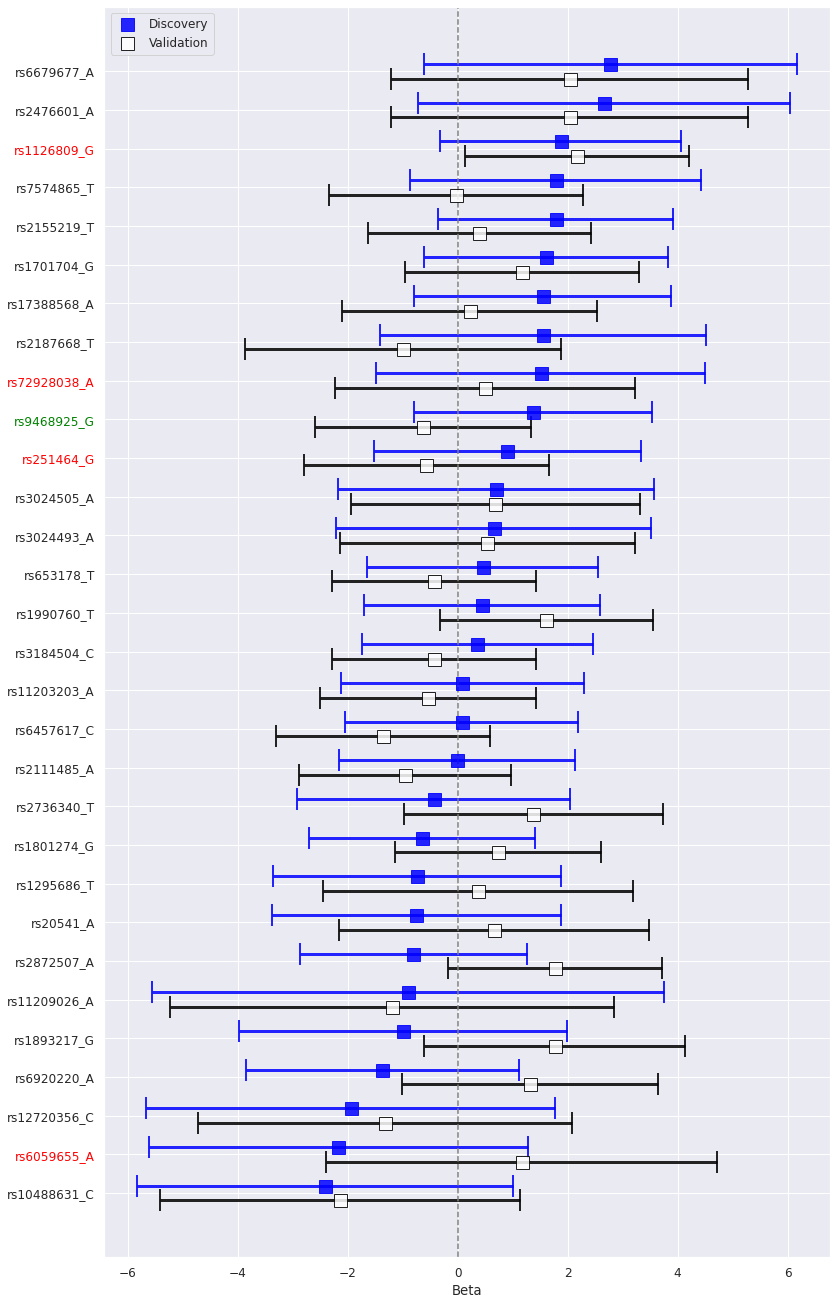

In [36]:
#define melanoma-vitiligo SNPs and psoriasis-vitiligo SNP (in between HLA-C/HLA-B) for visualization:
melanomaAndVitiligoSNPs = {"rs251464","rs72928038","rs1126809","rs1129038","rs6059655"}
hlaSNP = "rs9468925"

#Generate figure
sns.set(font_scale = 1.1)
fig, ax = plt.subplots(figsize = (13, 23))

transform1 = Affine2D().translate(0, 0.19) + ax.transData
transform2 = Affine2D().translate(0, -0.19) + ax.transData 

plt.errorbar(summaryDF.Beta_TCGA, summaryDF.index, xerr=summaryDF.TCGA_2_sigma, fmt = 's', mfc = "blue",color='blue',
             ecolor ='blue', elinewidth = 3, capsize = 11, markersize = 13, capthick = 2, alpha = 0.85, label = "Discovery", transform = transform1)
plt.errorbar(summaryDF.Beta_UKBB, summaryDF.index, xerr = summaryDF.UKBB_2_Sigma, fmt = "s", mfc = "white", color = "black",
             ecolor = "black", elinewidth = 3,capsize = 11, markersize = 13, capthick = 2, alpha = 0.85, label = "Validation", transform = transform2)

plt.xlabel("Beta")

plt.draw() #Needed for y-tick labels to be populated...
for i in range(len(ax.get_yticklabels())):
    if ax.get_yticklabels()[i].get_text().split("_")[0] in melanomaAndVitiligoSNPs:
        ax.get_yticklabels()[i].set_color("red")
    elif ax.get_yticklabels()[i].get_text().split("_")[0] == hlaSNP:
        ax.get_yticklabels()[i].set_color("green")

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles, labels, loc = "upper left")
plt.axvline(0, linestyle = "--", color = "gray")

**Are any of these SNP effect significant in either or both cohorts after multiple hypothesis correction:**

TCGA:

In [37]:
tcgaSignificance = multipletests(pvals = summaryDF.p_TCGA, alpha = 0.1, method = "fdr_bh")
tcgaSignificance 

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([0.624     , 0.624     , 0.67285714, 0.67285714, 0.81444444,
        0.81444444, 0.81444444, 0.81444444, 0.81444444, 0.81444444,
        0.81444444, 0.985     , 0.97862069, 0.97862069, 0.81444444,
        0.81444444, 0.81444444, 0.81444444, 0.81444444, 0.81444444,
        0.624     , 0.67285714, 0.67285714, 0.624     , 0.624     ,
        0.624     , 0.624     , 0.624     , 0.624     , 0.624     ]),
 0.0035058572695848556,
 0.0033333333333333335)

UKBB:

In [38]:
ukbbSignificance = multipletests(pvals = summaryDF.p_UKBB, alpha = 0.1, method = "fdr_bh")
ukbbSignificance 

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([0.74727273, 0.79777778, 0.79777778, 0.74727273, 0.74727273,
        0.79777778, 0.74727273, 0.79777778, 0.84964286, 0.79777778,
        0.74727273, 0.79777778, 0.74727273, 0.79777778, 0.79777778,
        0.74727273, 0.79777778, 0.79777778, 0.79777778, 0.79777778,
        0.79777778, 0.79777778, 0.79777778, 0.88137931, 0.74727273,
        0.79777778, 0.975     , 0.74727273, 0.74727273, 0.74727273]),
 0.0035058572695848556,
 0.0033333333333333335)

*After MH correction, neither cohort exhibited significant AI SNP effects with age of diagnosis (see above 2 cells)*